<center>  <h1> Demo 4: Batch Normalization </h1> </center> 
<center> Jillian Fisher, Zaid Harchaoui </center>
    <center> Data 598 (Winter 2023), University of Washington </center>
    <center>  </center>
    

In this demo, we will talk about convolutions in the context of images and text. 

Recall that a multilayer perceptron (MLP), which interleaved linear maps with non-linear activations, required us to flatten an image. That destroys the spatial structure of the image. 

A natural way to preserve spatial structure of images to perform a different linear operation known as the convolution. A neural network obtained with convolutions as (some of) the linear maps is a convolutional neural network. 

In this demo, we will motivate the convolution by using a related notion of a *correlation filter*.


This notebook is inspired by the [D2L book](https://d2l.ai/), http://debajyotidatta.github.io/nlp/deep/learning/word-embeddings/2016/11/27/Understanding-Convolutions-In-Text/, https://tzuruey.medium.com/using-convolution-neural-networks-to-classify-text-in-pytorch-3b626a42c3ca,  and adapted from lecture material created by Krishna Pillutla.

**What is a convolution?**

Consider an image $I$ denoted by a matrix of size $m \times n$. 
We typically convolve an image with what is known as a convolutional kernel or filter $k$, 
which is denoted as a matrix. For convenience, we let $k$ be of size $(2m'+1) \times (2n' + 1)$.
Typically, we have, $m' \ll m, n' \ll n$ and that the kernel matrix's dimensions $2m'+1, 2n'+1$ are odd integers.

The convolution of an image $I$ with kernel $k$, denoted $I \star k$, is defined as 
$$
    (I \star k)[x, y] =  \sum_{a=-m'}^{m'} \sum_{b=-n'}^{n'} k[a, b] \, I[x + a, y + b]
$$
where we index $k$ from $-m'$ to $m'$ and $-n'$ to $n'$ for convenience. 

The GIF below (source [here](https://miro.medium.com/max/700/1*Fw-ehcNBR9byHtho-Rxbtw.gif)) shows a $3 \times 3$ convolution on a image.

<img src="https://miro.medium.com/max/700/1*Fw-ehcNBR9byHtho-Rxbtw.gif" width="500">

**NOTE**: The word "kernel" can mean multiple different things in machine learning. In this context, it is a small matrix (e.g. size $5 \times 5$) that is applied as defined above. It has nothing to do with kernels in kernel SVMs or in kernel smoothing. 


**Illustration**:
Let us illustrate the action of a simple kernel, which computes how different a pixel is from its four neighbors. In particular, we use the kernel
$$
    k = \begin{pmatrix} 0 & -1 & 0 \\ -1 & 4 & -1 \\ 0 & -1 & 0 \end{pmatrix} .
$$
When convolved with this kernel, note that the $(x, y)$ pixel is 
$$
    (I \star k)[x, y] = 4 I[x, y] - I[x+1, y] - I[x-1, y] - I[x, y+1] - I[x, y-1].
$$
This kernel detects sudden changes in pixel testues, in other words, edges. 

In [45]:
from PIL import Image
from scipy.signal import correlate
import numpy as np
import requests
from io import BytesIO

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

convolutional kernel =
 [[ 0 -1  0]
 [-1  4 -1]
 [ 0 -1  0]]


/var/folders/__/vmn4s2rd6755rfl9h22x7pzr0000gn/T/ipykernel_33605/2713657484.py:8: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  image_graysacle = image.convert('L').resize((60, 64), Image.BILINEAR)


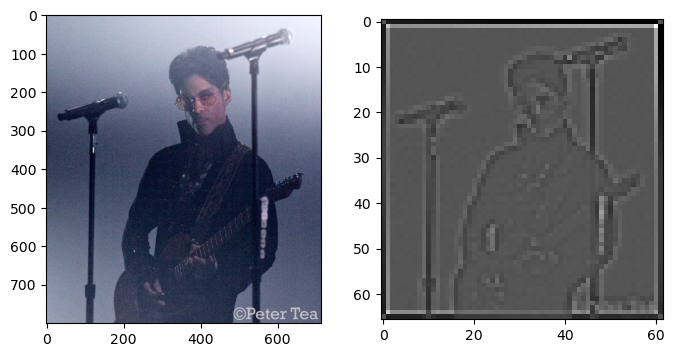

In [46]:
image_url = "https://live.staticflickr.com/6001/5932635601_482f3e58d7_c.jpg"  # Give your own!

# Load image
r = requests.get(image_url, stream=True)
image = Image.open(BytesIO(r.content))

# Convert to grayscale (Convolutions in color works much the same way)
image_graysacle = image.convert('L').resize((60, 64), Image.BILINEAR)

f, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(image, cmap='gray')
kernel =  np.asarray([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])

print("convolutional kernel =\n", kernel)

convolved_image = correlate(image_graysacle, kernel)
ax[1].imshow(convolved_image, cmap='gray')

## Convolutions as correlations

The convolution operation we have defined above is also know as a **correlation filter**. A correlation filter searches through the various patches of an image and produces a peak when a patch resembles the filter. 

**Note**: Strictly speaking, the mathematical definitions of a *convolution* and a *correlation filter* differ in flipping the kernel. With some abuse of nomenclature, we will use these terms interchangeably. 


### Dataset and Task
For this part, we will use use the LFW dataset (Labeled Faces in the Wild). We will try to create a lightweight "nose detector" in images. 
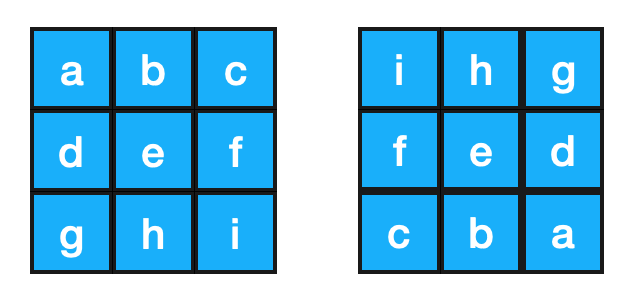

In [47]:
import torch
import numpy as np
import sklearn.datasets

In [48]:
# Download dataset
dataset = sklearn.datasets.fetch_lfw_people(data_home='./data')  # downloads dataset (350 MB), takes a few minutes
images = dataset.images
labels = dataset.target
print(images.shape)  # 13233 gray scale images of size 62 x 47

(13233, 62, 47)


Let us visualize some images now. 

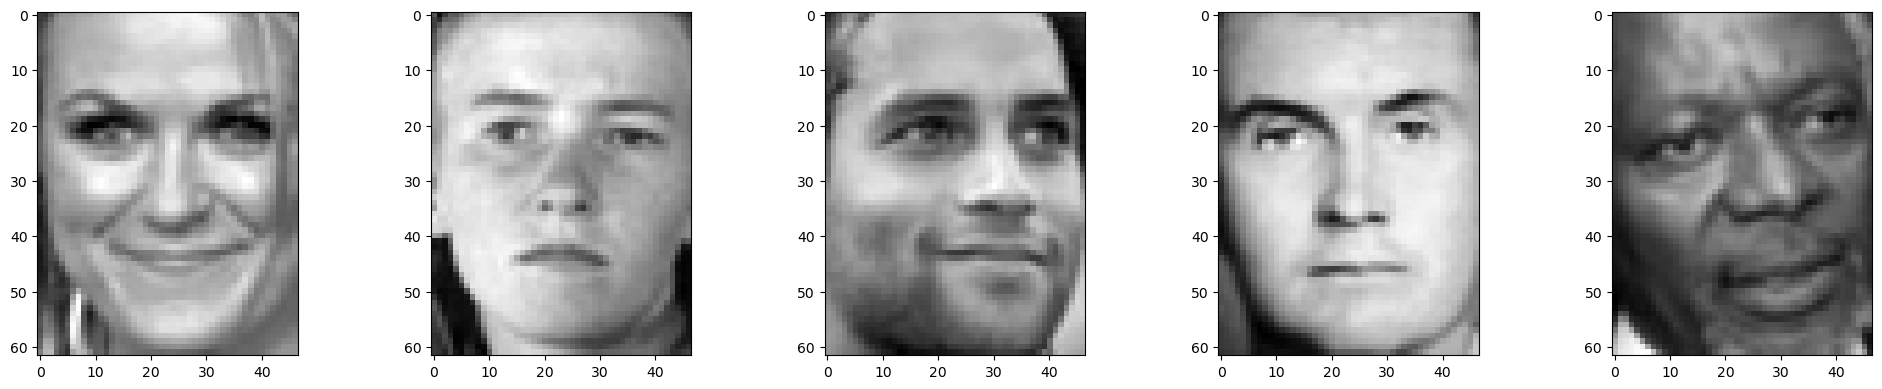

In [49]:
f, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    ax[i].imshow(images[np.random.randint(images.shape[0])], cmap='gray')
plt.tight_layout()

Let us select all the images of one person, Serena Williams. 

In [50]:
selected_label = 4963 # the label corresponding to Serena Williams 
selected_images = images[labels==selected_label]
print(selected_images.shape)  # 52 images

(52, 62, 47)


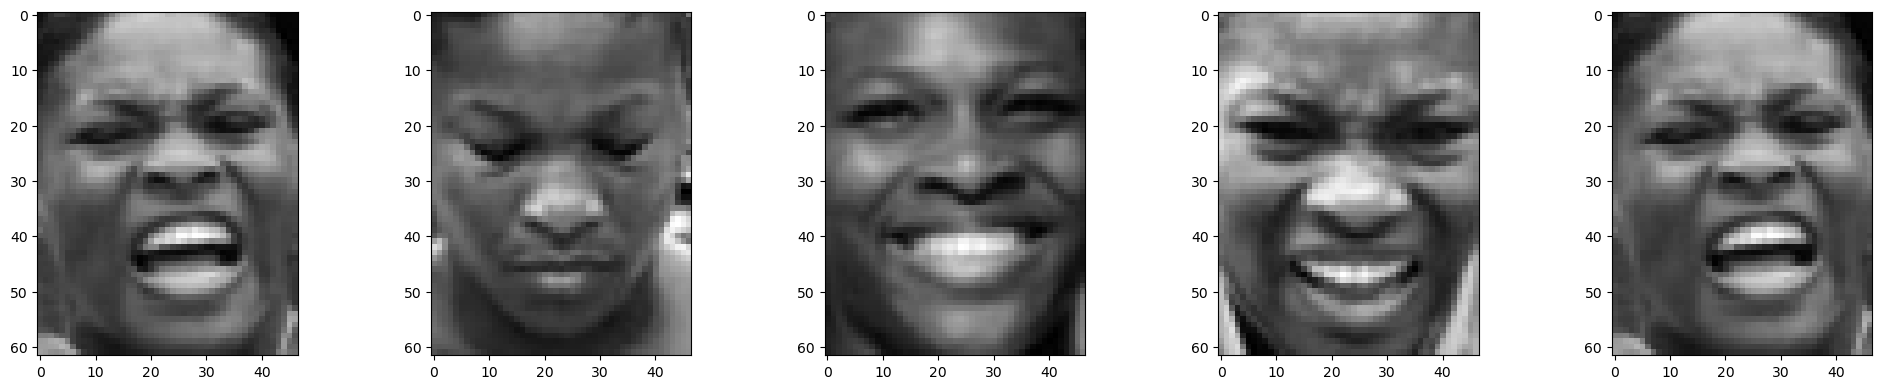

In [51]:
f, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    ax[i].imshow(selected_images[np.random.randint(selected_images.shape[0])], cmap='gray')
plt.tight_layout()

We will try to build a "nose detector" using an image of Serena's nose as a filter. 

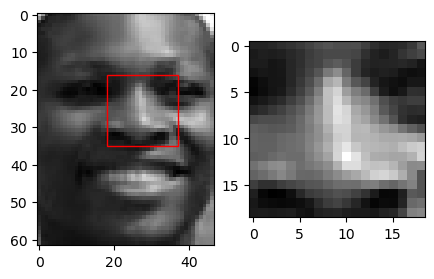

In [52]:
f, ax = plt.subplots(1, 2, figsize=(5, 4))
image = selected_images[2]
ax[0].imshow(image, cmap='gray')

y, x, h, w = 16, 18, 19, 19
rect = mpl.patches.Rectangle((x,y),h,w,linewidth=1,edgecolor='r',facecolor='none')
ax[0].add_patch(rect)

patch = image[y:y+h, x:x+w]
ax[1].imshow(patch, cmap='gray')

We center each path and make it unit norm. This is to account for varying levels of brightness and contrast in the images. 

Let us code up the correlation filter now. We iterate over each patch (of a given size) in the image and compute its dot product with the filter. 
Let us see if the image of a nose can be used to identify noses in other images of Serena with different angles, lighting and expressions.

In [53]:
def center_image(image):  
    # normalize to reduce effects of brightness and contrast
    image = image - image.mean()
    return image / np.linalg.norm(image.reshape(-1))

In [54]:
def correlation_filter(image, patch):
    h, w = image.shape
    h1, w1 = patch.shape
    output = np.zeros((h-h1+1, w-w1+1))
    for i in range(h-h1+1):
        for j in range(w-w1+1):
            image1 = center_image(image[i:i+h1, j:j+w1]).reshape(-1)
            patch1 = center_image(patch.reshape(-1))
            output[i, j] = np.dot(patch1, image1)  

    # embed output in the center of an image and zero pad it
    new_output = np.zeros_like(image)
    new_output[h1//2:h1//2+output.shape[0], w1//2:w1//2+output.shape[1]] = output
    return new_output

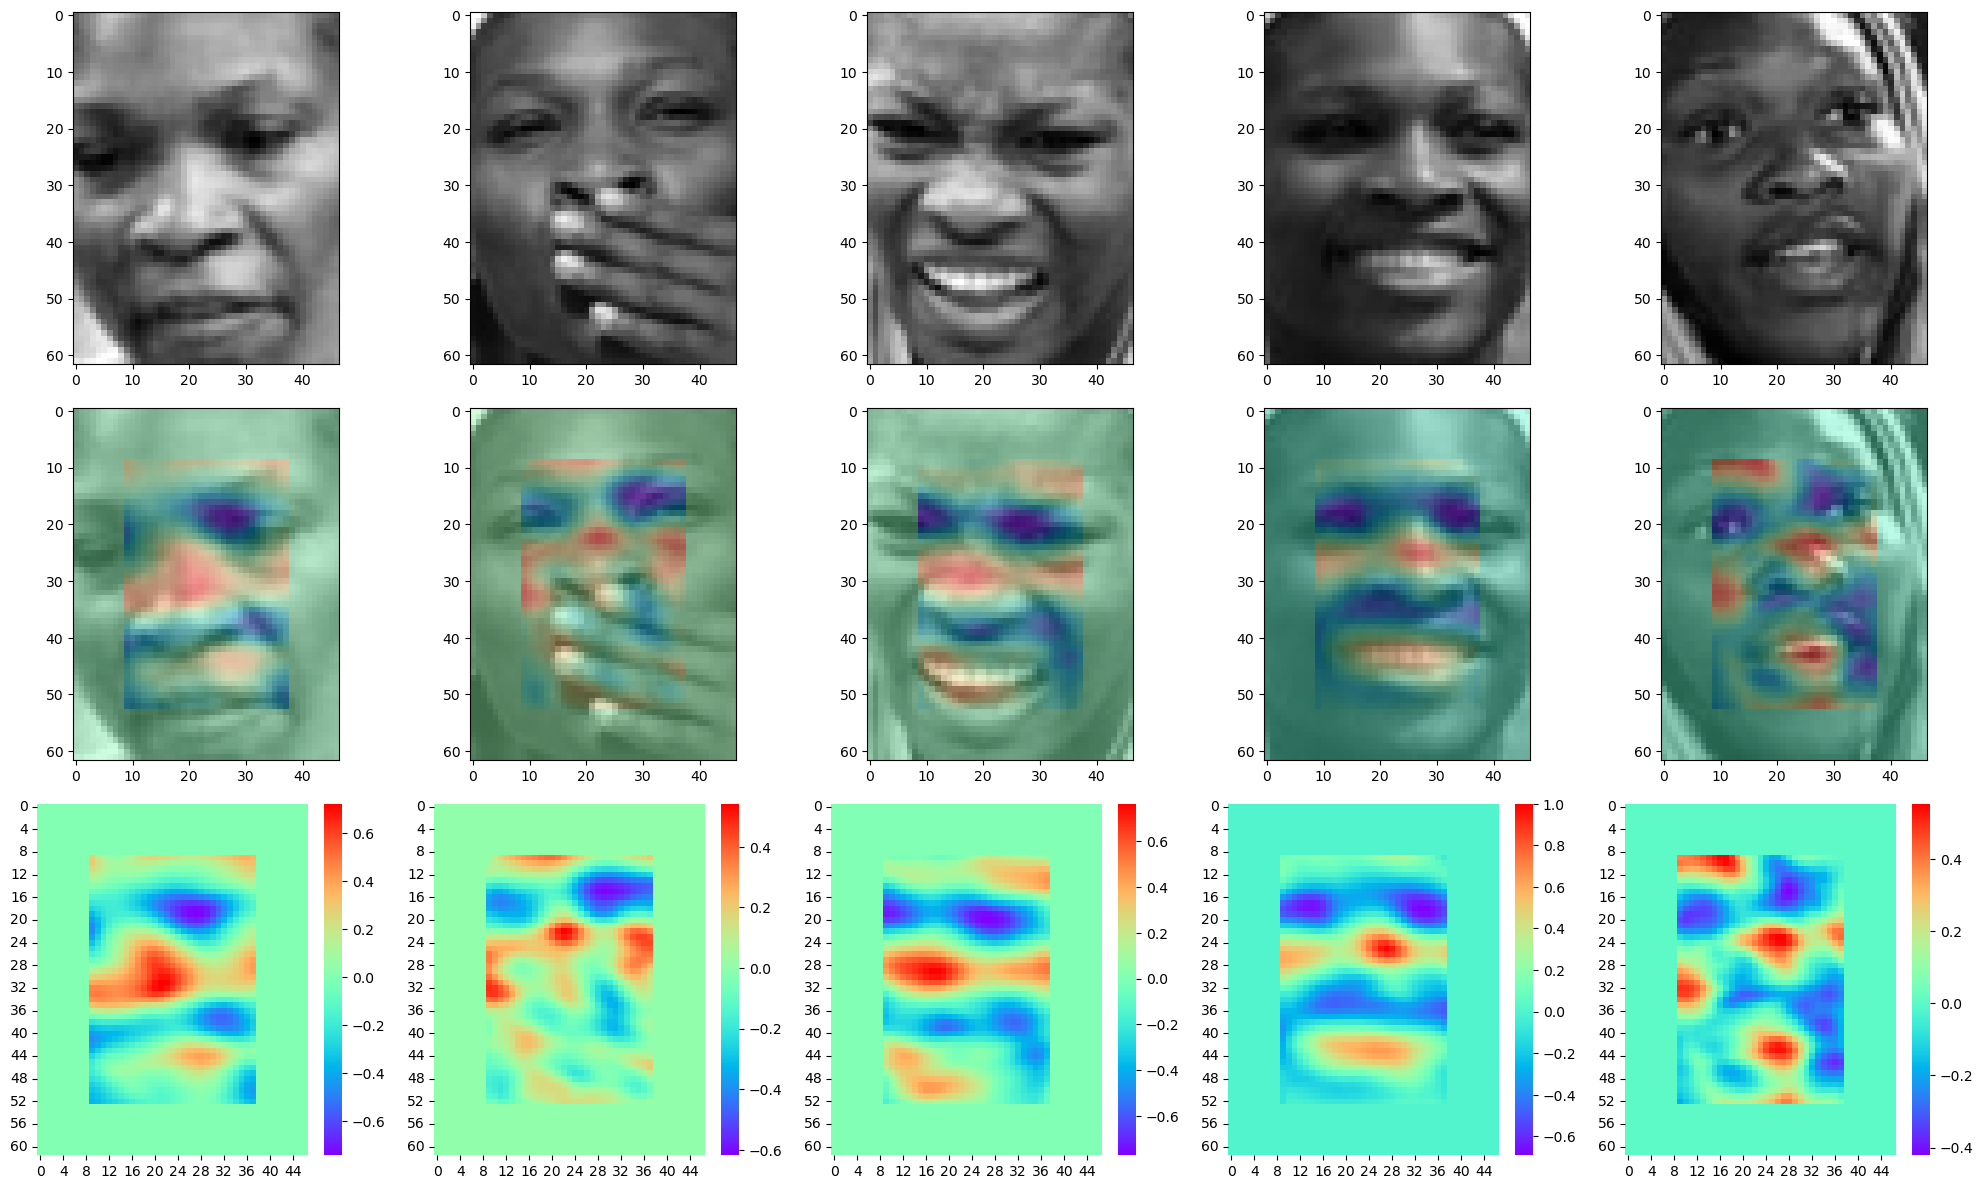

In [55]:
f, ax = plt.subplots(3, 5, figsize=(20, 12))
for i in range(5):
    img = selected_images[np.random.randint(selected_images.shape[0])]
    ax[0, i].imshow(img, cmap='gray')
    ax[1, i].imshow(img, cmap='gray')
    mask = correlation_filter(center_image(img), patch)
    # mask = correlation_filter((img - mean)/std, patch)
    ax[1, i].imshow(mask, alpha=0.4, cmap='rainbow')
    # ax[2, i].imshow(mask, cmap='rainbow')  # does not show colorbar
    sns.heatmap(mask, ax=ax[2, i], cmap='rainbow')
plt.tight_layout()

Let us check if our "nose detector" works on images of completely different people.

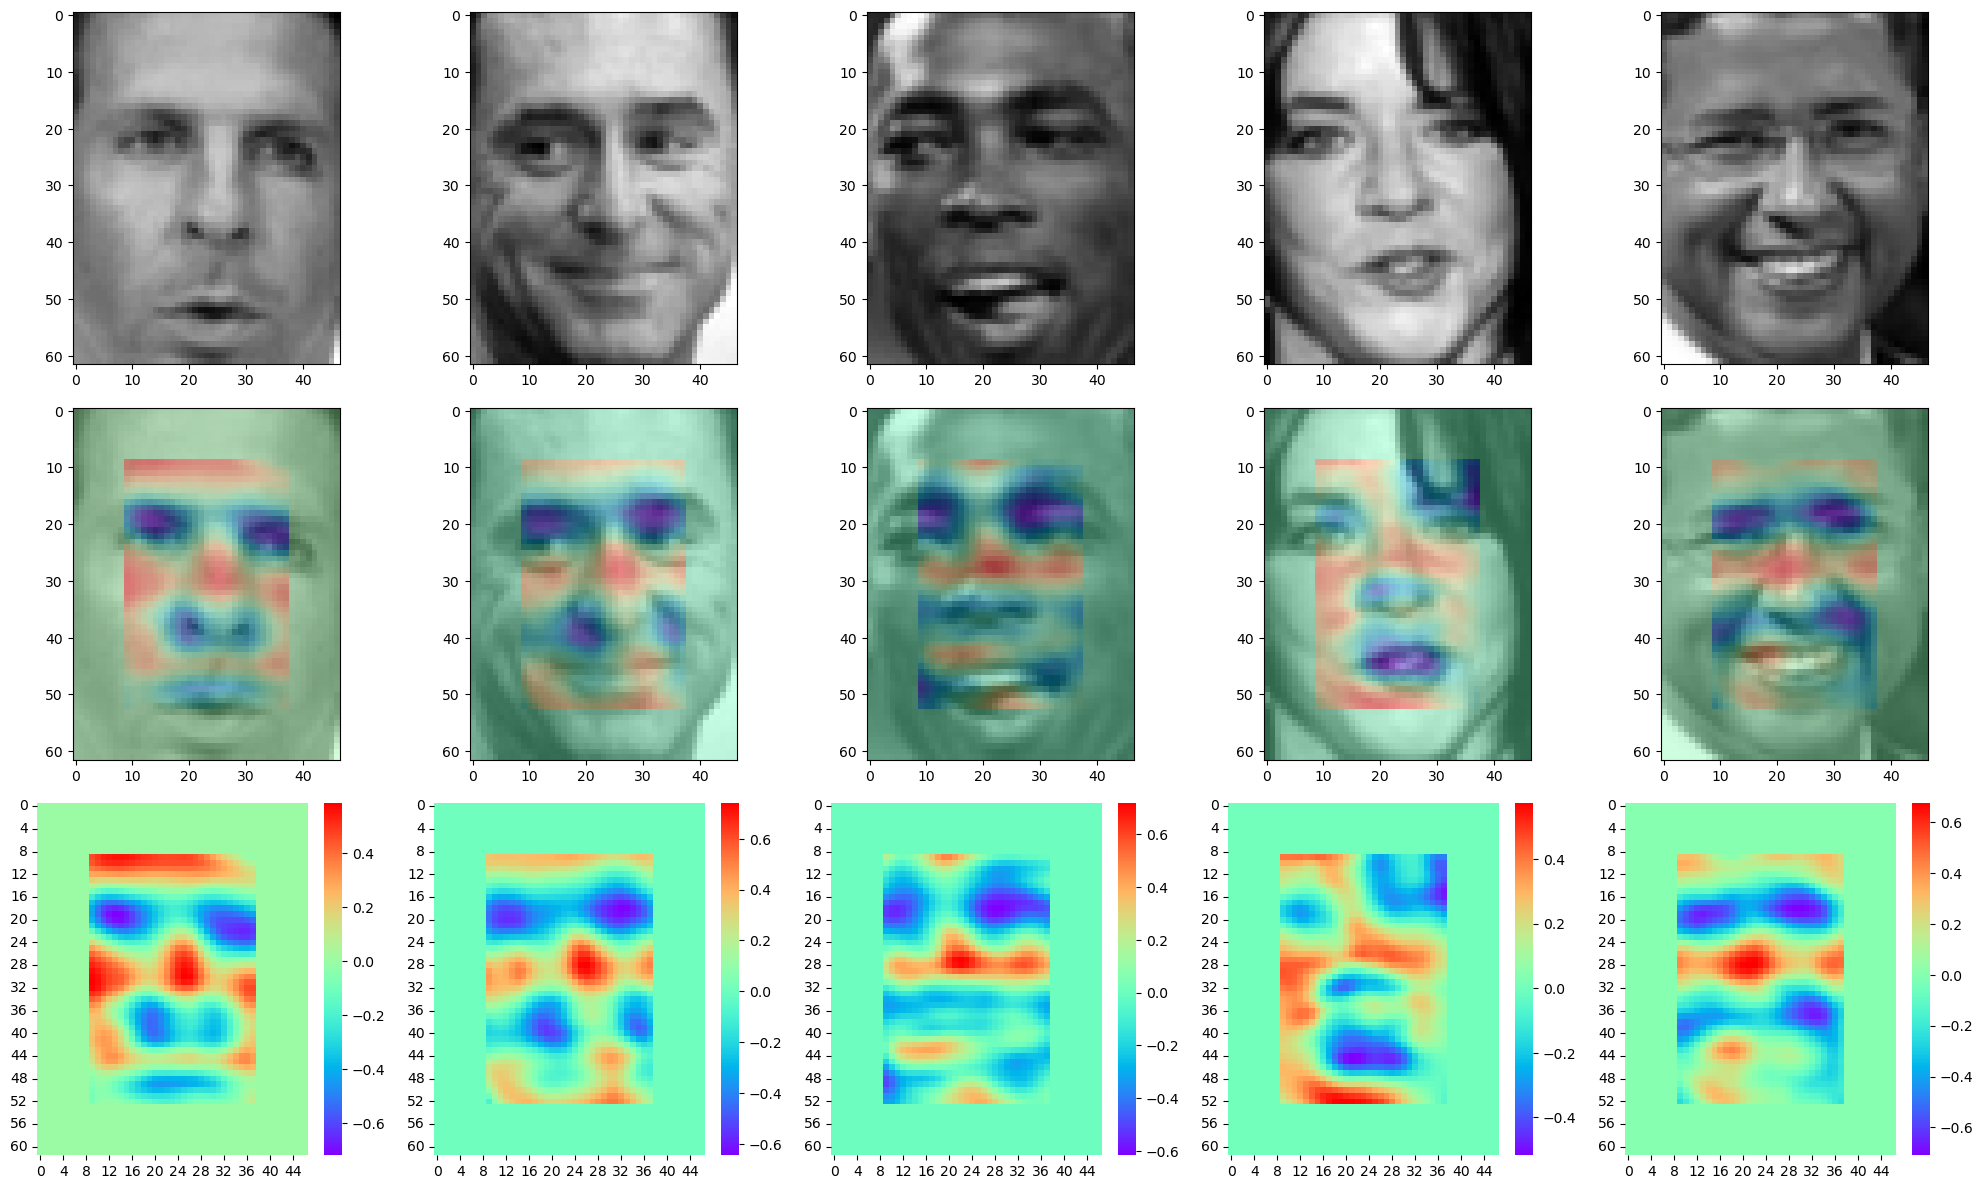

In [56]:
f, ax = plt.subplots(3, 5, figsize=(20, 12))
for i in range(5):
    img = images[np.random.randint(images.shape[0])]
    ax[0, i].imshow(img, cmap='gray')
    ax[1, i].imshow(img, cmap='gray')
    mask = correlation_filter(center_image(img), patch)
    # mask = correlation_filter((img - mean)/std, patch)
    ax[1, i].imshow(mask, alpha=0.4, cmap='rainbow')
    # ax[2, i].imshow(mask, cmap='rainbow')  # does not show colorbar
    sns.heatmap(mask, ax=ax[2, i], cmap='rainbow')
plt.tight_layout()

Let us redo this exercise to build an "eye detector".

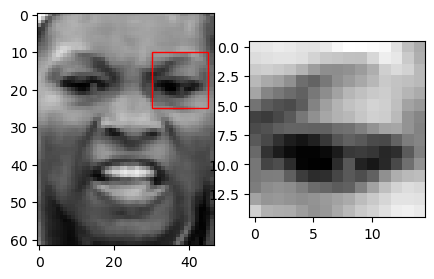

In [57]:
f, ax = plt.subplots(1, 2, figsize=(5, 4))
image = selected_images[16]
ax[0].imshow(image, cmap='gray')

# Create a Rectangle patch
y, x, h, w = 10, 30, 15, 15
rect = mpl.patches.Rectangle((x,y),h,w,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax[0].add_patch(rect)

patch = image[y:y+h, x:x+w]
ax[1].imshow(patch, cmap='gray')

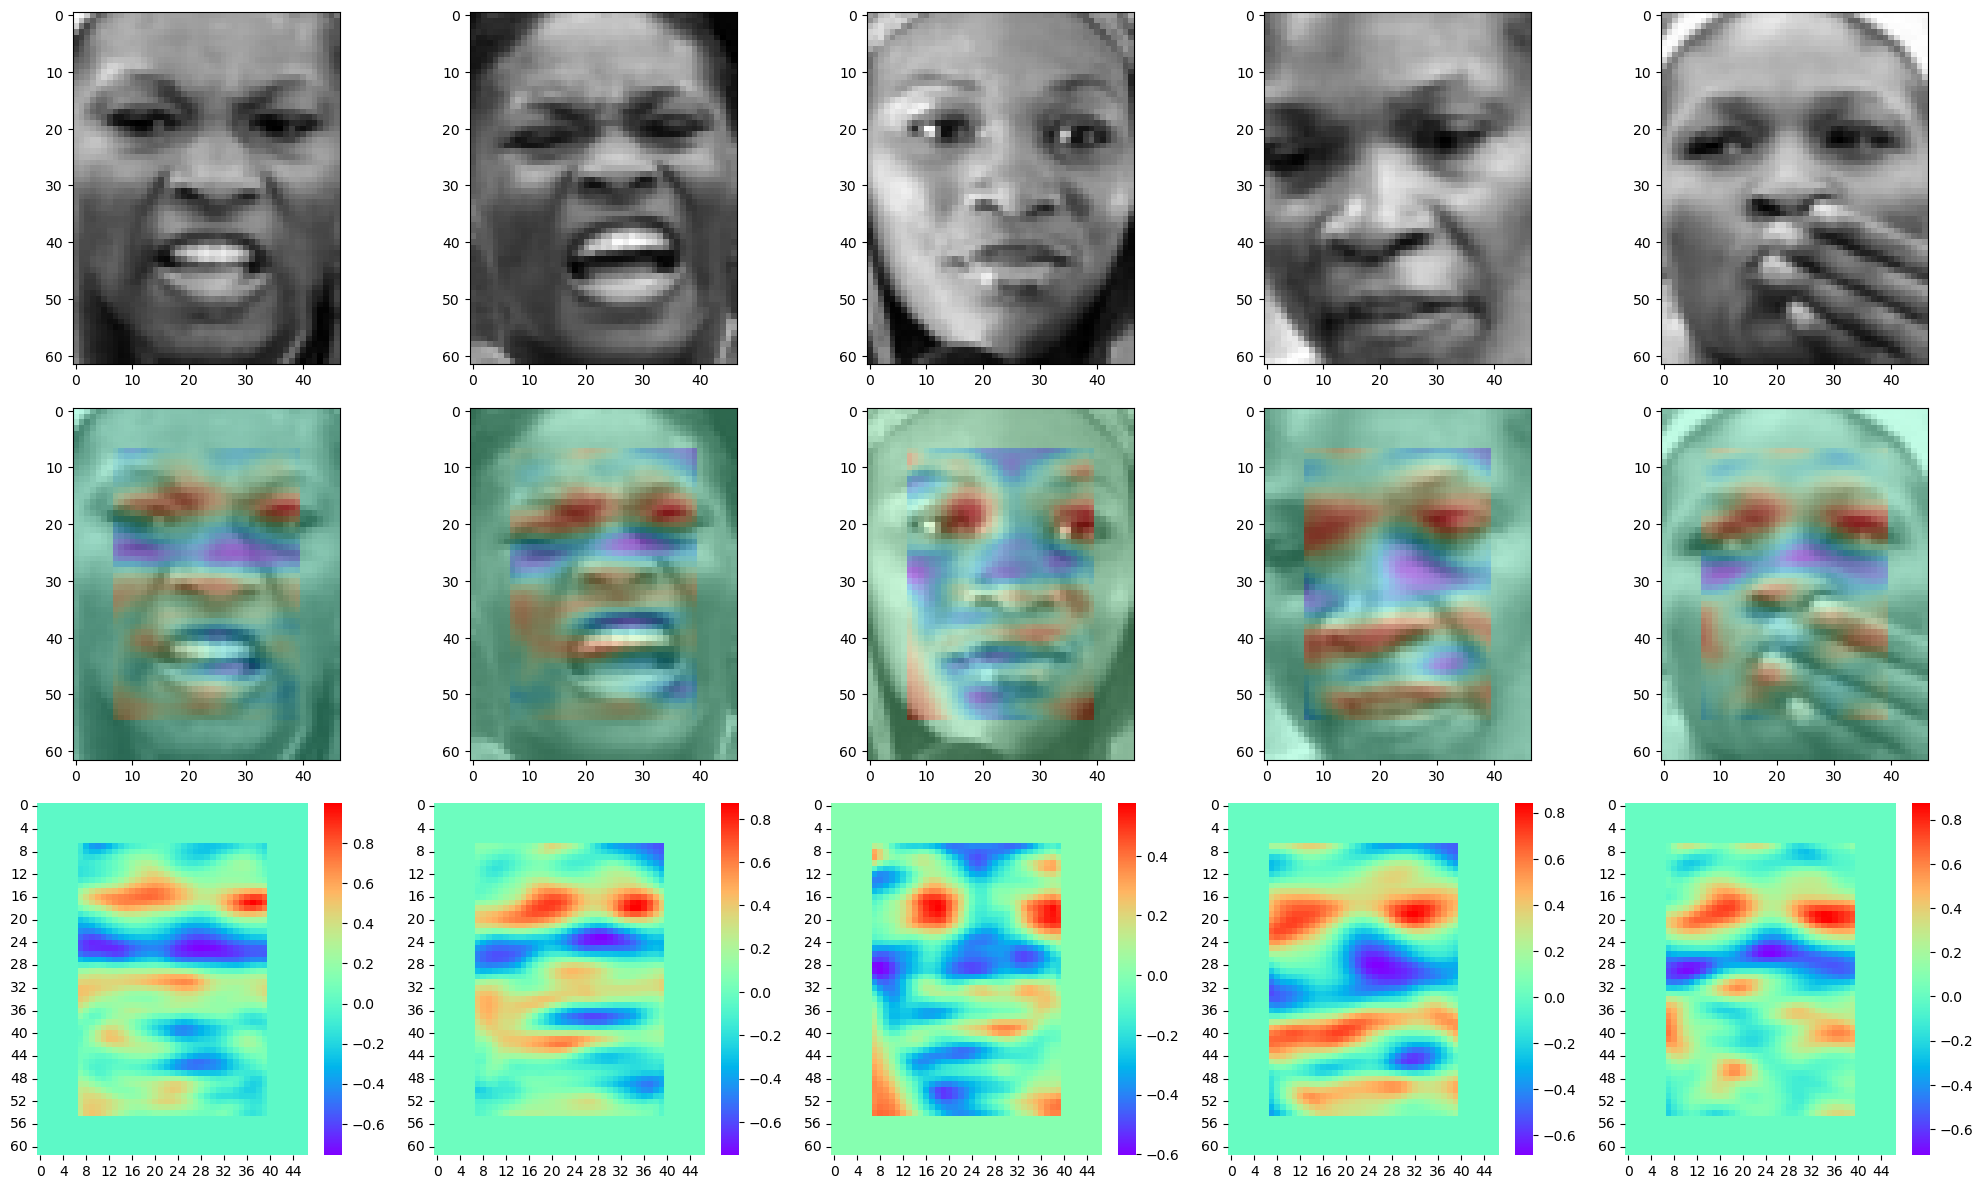

In [58]:
f, ax = plt.subplots(3, 5, figsize=(20, 12))
for i in range(5):
    img = selected_images[np.random.randint(selected_images.shape[0])]
    ax[0, i].imshow(img, cmap='gray')
    ax[1, i].imshow(img, cmap='gray')
    mask = correlation_filter(center_image(img), patch)
    # mask = correlation_filter((img - mean)/std, patch)
    ax[1, i].imshow(mask, alpha=0.4, cmap='rainbow')
    #ax[2, i].imshow(mask, cmap='rainbow') # does not show colorbar
    sns.heatmap(mask, ax=ax[2, i], cmap='rainbow')
plt.tight_layout()

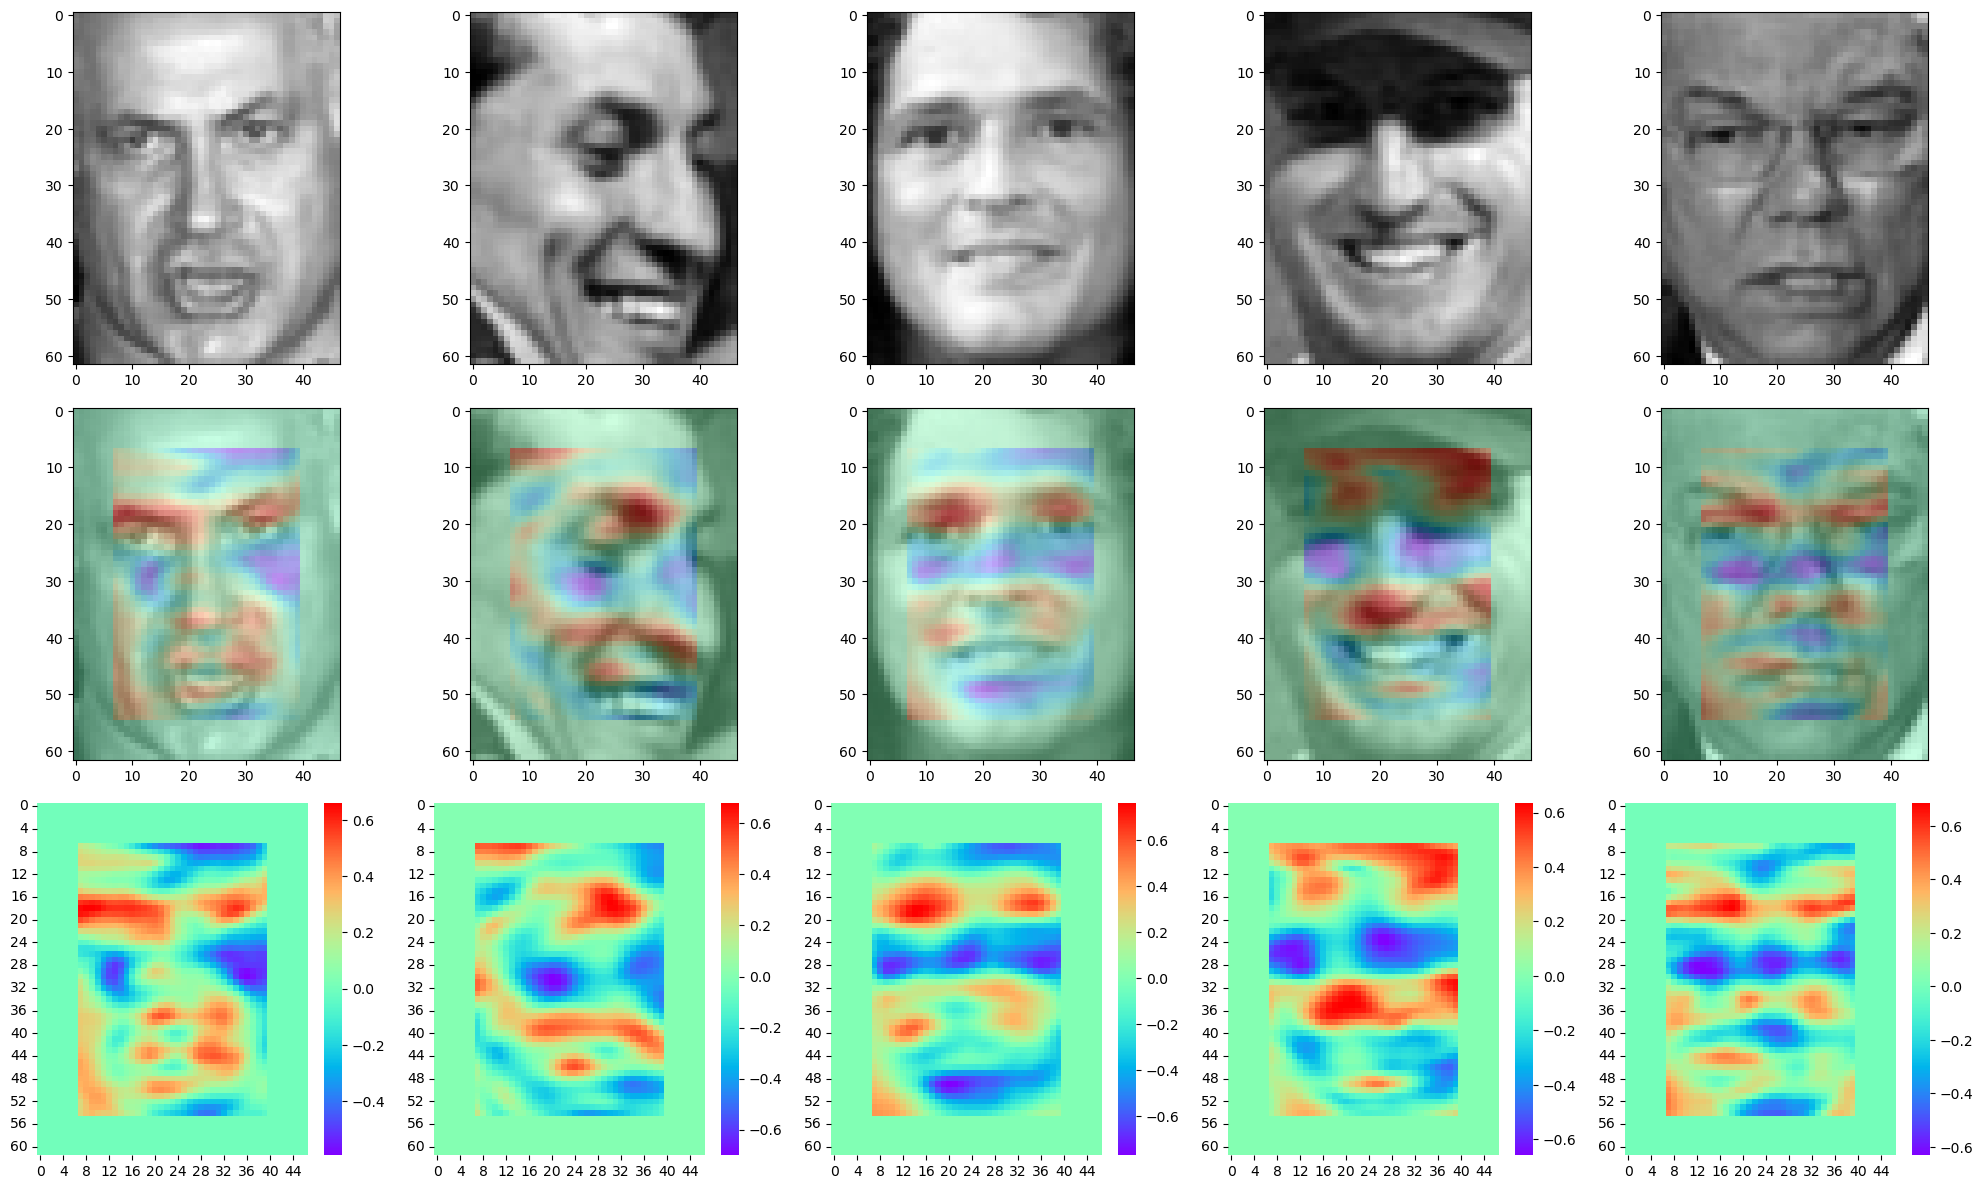

In [59]:
f, ax = plt.subplots(3, 5, figsize=(20, 12))
for i in range(5):
    img = images[np.random.randint(images.shape[0])]
    ax[0, i].imshow(img, cmap='gray')
    ax[1, i].imshow(img, cmap='gray')
    mask = correlation_filter(center_image(img), patch)
    # mask = correlation_filter((img - mean)/std, patch)
    ax[1, i].imshow(mask, alpha=0.4, cmap='rainbow')
    # ax[2, i].imshow(mask, cmap='rainbow') # does not show colorbar
    sns.heatmap(mask, ax=ax[2, i], cmap='rainbow')
plt.tight_layout()

## Visualizing kernels in a convolutional neural network

The convolutional kernels/filters in a neural network learn to identify very particular 
patterns in images, much like the simple "nose/eye detectors we saw above". 
We will now visualize some filters.

In [60]:
@torch.no_grad()
def visualize_conv_kernel(conv_layer, channel=0, nrow=8): 
    # source: https://github.com/pedrodiamel/nettutorial/blob/master/pytorch/pytorch_visualization.ipynb
    kernel = conv_layer.weight
    n, c, w, h = kernel.shape
    kernel = kernel[:, channel:channel+1, :, :]
    rows = np.min((kernel.shape[0]//nrow + 1, 64))    
    grid = torchvision.utils.make_grid(kernel, nrow=nrow, normalize=True, padding=1)
    plt.figure(figsize=(nrow,rows))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [61]:
import torchvision
model = torchvision.models.resnet50(pretrained=True)

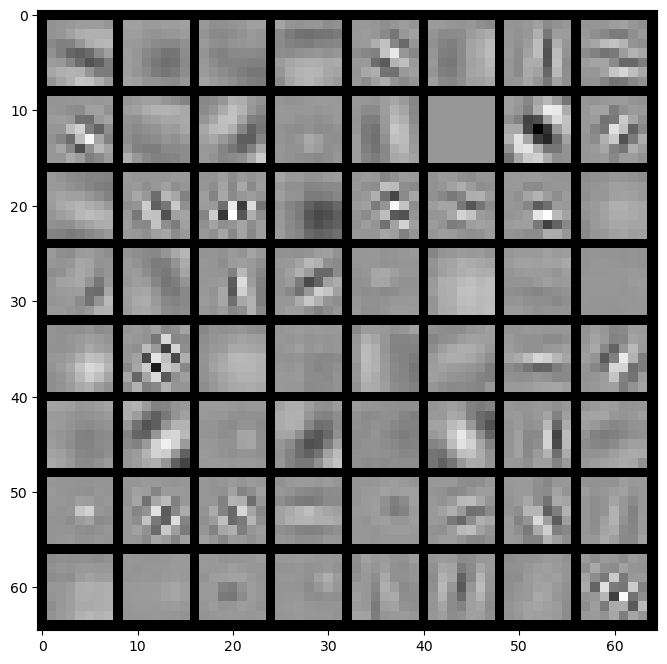

In [62]:
visualize_conv_kernel(model.conv1, channel=2)

We can compare this to a randomly initialized model, whose kernels/filters looks like noise.

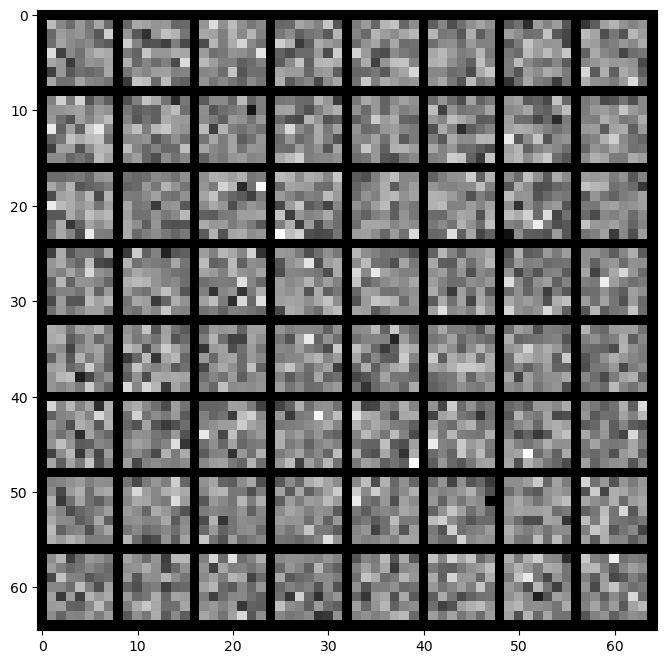

In [63]:
model2 = torchvision.models.resnet50(pretrained=False)
visualize_conv_kernel(model2.conv1, channel=1)

In [64]:
# Download Gif for Below
%%capture
!pip install gdown
import gdown
# https://drive.google.com/file/d/1NqtTL8YueVWKiAp7MUMsjXqAHrlNat7t/view?usp=sharing
url = 'https://drive.google.com/uc?id=1NqtTL8YueVWKiAp7MUMsjXqAHrlNat7t'
output = 'CNN_text.gif'
gdown.download(url, output, quiet=False)

UsageError: Line magic function `%%capture` not found.


## Example of CNN for Text Classification
CNN's can also be used on text dataset, for example text classification. We will use the Text REtrietest Conference (TREC) Question Classifiction data, which is composed of an input (a question) and a label (a category type) related to the input. 

The 6 cateogires are: 

"ABBR": Abbreviation

"ENTY": Entity

"DESC": Description

"HUM": Human

"LOC": Location

"NUM": Numeric
## Text to Vectors
When using text we need to first translate a word into a vector of numbers (tokenization). We will go into more detail about different methods of tokenization, but for now we introduce one-hot encoding for text. It creates a vectors of size equal to the number of words in the dataset. Then, each word is translated into a vector by placing a 1 in the position of the word and a 0 everywhere else. 

<img src="https://cdn-images-1.medium.com/max/1600/1*0kkqYg0mGpyvqvrMam2k2A.png" width="400">


## CNN for Text
CNN's for text are very similar as images, except the width of the filter has to be the same dimension as the length of one token. For example, if you are using one-hot encoding with a vocabulary size as n, then the width of each filter must be n as well.

<img src="http://debajyotidatta.github.io/assets/images/Zhang.png" width="400">

See the below gif for more details on the process. 

![CNNText](CNN_text.gif "segment") 


In [65]:
# Install Spacy and spacy dictionary
%%capture
# If this give an error, in your terminal activate the data598 env "conda activate data598" and then install each
#package seperately: "pip install spacy", "python3 -m spacy download en_core_web_sm"
import pip
!pip install spacy
import spacy

!python3 -m spacy download en_core_web_sm


UsageError: Line magic function `%%capture` not found.


In [66]:
# Download Text REtrietest Conference (TREC) Question Classifiction data (https://cogcomp.seas.upenn.edu/Data/QA/QC/)
import requests

# Training Data
URL = "https://cogcomp.seas.upenn.edu/Data/QA/QC/train_1000.label"
TREC_train_data = str(requests.get(URL).content).split("\\n")
train_label = []
train_input = []
for i, t in enumerate(TREC_train_data[:-1]):
    if i ==0:
        train_label.append(t.split(":")[0][2:])
    else:
      train_label.append(t.split(":")[0])
    train_input.append(" ".join(t.split(":")[1].split(" ")[1:]))

train={"input":train_input, "label":train_label}

# Test Data
URL = "https://cogcomp.seas.upenn.edu/Data/QA/QC/TREC_10.label"
TREC_test_data = str(requests.get(URL).content).split("\\n")
test_label = []
test_input = []
for i, t in enumerate(TREC_test_data[:-1]):
    if i ==0:
        test_label.append(t.split(":")[0][2:])
    else:
      test_label.append(t.split(":")[0])
    test_input.append(" ".join(t.split(":")[1].split(" ")[1:]))
test={"input":test_input, "label":test_label}

print("Example of Input/Label")
print("Input:", train_input[1])
print("Label:", train_label[1])

np.unique(list(train['label'])+list(test['label']))


Example of Input/Label
Input: What films featured the character Popeye Doyle ?
Label: ENTY


array(['ABBR', 'DESC', 'ENTY', 'HUM', 'LOC', 'NUM'], dtype='<U4')

In [67]:
# Change string label to integer label
from sklearn import preprocessing
import numpy as np

le = preprocessing.LabelEncoder()
le.fit(train['label']+test['label'])
train['categorical_label'] = le.transform(train['label'])
test['categorical_label'] = le.transform(test['label'])
print("New Label:", train['categorical_label'][1])
print("Nclasses:", len(np.unique(list(train['categorical_label'])+list(test['categorical_label']))))


New Label: 2
Nclasses: 6


In [68]:
import spacy
spacy.load('en_core_web_sm')
nlp = spacy.load('en_core_web_sm')

#  extract features training_data
train_input_vec = [[nlp(v).vector] for v in train['input']]  
test_input_vec = [[nlp(v).vector] for v in test['input']]

print("Length of One word Vector:", len(train_input_vec[0][0]))
print("Word Vector Example: ", train_input_vec[1])

Length of One word Vector: 96
Word Vector Example:  [array([ 0.05669461,  0.14431228, -0.09996024,  0.24405436,  0.17144223,
       -0.00698099,  0.5538776 , -0.04801345,  0.10472064, -0.0724301 ,
        0.46154702,  0.6193586 , -0.2742111 , -0.36640358, -0.41472915,
       -0.3367687 , -0.80017823,  0.01405566,  0.37896937, -0.26699197,
        0.06921677,  0.1596782 ,  0.4810588 , -0.59376097,  0.54818946,
        0.47652596,  0.55965155, -0.21928822,  0.08473992,  0.5288323 ,
       -0.47222984, -0.03617568, -0.03886646, -0.4117626 , -0.05733662,
        0.00477944, -0.20796035,  0.08200786,  0.00801046,  0.29752997,
       -0.22893679,  0.33473495,  0.16553667, -0.12274137, -0.3228015 ,
       -0.28731245,  0.04599106,  0.05031565,  0.18770975,  0.06129264,
       -0.1034981 , -0.06582367,  0.57545704,  0.15352717, -0.22472565,
       -0.04059392,  0.11420984,  0.40521163,  0.3088222 , -0.2678545 ,
       -0.24282809,  0.06950298, -0.37544304, -0.21284604,  0.14027752,
       -0.0

In [69]:
from torch import nn
import torch
from torch import optim
import torch.nn.functional as F
class SimpleCNN(nn.Module):
    def __init__(self, nclasses:int, linear_dimension:int,kernel_size, padding, window_size: int = 16, embedding_dim: int = 16,
    filter_multiplier: int = 64):
        super(SimpleCNN, self).__init__()
        self.simpleconv = nn.Conv2d(in_channels=1, out_channels=filter_multiplier, stride=CONV_STRIDE, kernel_size=kernel_size, padding=padding)
        self.maxpool = nn.MaxPool2d(kernel_size=kernel_size, stride=CONV_STRIDE, padding=padding)
        self.linear = nn.Linear(linear_dimension, out_features=nclasses)
        self.softmax = nn.LogSoftmax(1)
    
    def forward(self, x, **kwargs): # shape: (batch, 16, 96)
        # input x is already embedding vectors from spaCy
        # set the channel dim to a new dimension that’s just 1
        x = torch.transpose(x, 1, 2) # (batch, 1, 96)
        x = torch.unsqueeze(x, 1) # (batch, 1, 96, 1)
        x = self.simpleconv(x) # (batch, 64, 48, 1)
        x = self.maxpool(x) # (batch, 64, 24, 1) 
        F.relu(x) # non-linear function to activate the neurons
        x = x.flatten(start_dim=1) # (batch, 1536)
        x = self.linear(x)
        F.relu(x)
        x = self.softmax(x)
        return x

In [70]:
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)

def run_cnn_text(num_classes, batch_size, learning_rate, num_epochs, CONV_STRIDE, linear_dimention, kernel_size, padding):
  model = SimpleCNN(num_classes, linear_dimention, kernel_size, padding) 
  # Create Dataloaders
  train_inputs_tensor, test_inputs_tensor, train_label_tensor, test_label_tensor = tuple(torch.tensor(data) for data in[train_input_vec, test_input_vec, train['categorical_label'], test['categorical_label']])
  # Create DataLoader for training data
  train_data = TensorDataset(train_inputs_tensor, train_label_tensor)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  # Create DataLoader for testidation data
  test_data = TensorDataset(test_inputs_tensor, test_label_tensor)
  test_sampler = SequentialSampler(test_data)
  test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


  optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8)
  lossfn = nn.NLLLoss()
  for epoch in range(num_epochs):
    running_loss = 0.
    for i, batch in enumerate(train_dataloader): # create a new generator every epoch
      input, label  = b_input_ids, b_labels = tuple(t for t in batch)
      optimizer.zero_grad()
      outputs = model(input)
      loss = lossfn(outputs, label)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()


  model = model.eval()
  num_correct = 0
  num_examples = 0
  # Check accuracy
  for i, batch in enumerate(test_dataloader):
    y, target = batch
    output = model(y)
    y_pred = []
    for o in output:
      y_pred.append(torch.max(o, -1).indices.item()) # Choose class with highest option
    y_pred = torch.FloatTensor(y_pred)
    correct = torch.eq(torch.round(y_pred).type(target.type()), target).view(-1)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]
  print("Accuracy: ",  num_correct / num_examples)
  return(num_correct / num_examples)

In [71]:
# Train Model
num_classes = 6 
batch_size = 32
learning_rate = 0.1
num_epochs = 50
CONV_STRIDE = 2
linear_dimension = 1600
kernel_size = 3
padding = 1
linear_dimension = 1536


run_cnn_text(num_classes, batch_size, learning_rate, num_epochs, CONV_STRIDE, linear_dimension, kernel_size, padding)

Accuracy:  0.668


0.668